In [163]:
import pandas as pd
import re
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
%config Completer.use_jedi = False
%config IPCompleter.greedy = True
%matplotlib inline

In [164]:
d = pd.read_csv('../anibis_price.txt',sep='\t')

In [165]:
d.head()

,title,price,surface,rooms,object,location,canton
0,Attique magnifique,Gratuit,90 m2,3.0,Appartement,Montenol,Jura
1,A louer grand 2p. à Botterens avec garage et b...,CHF 1'050.–,NaN,2.0,Appartement,Botterens,Fribourg
2,Croix de Rozon 3 kms de Carouge à louer 4 pcs,CHF 2'150.–,80 m2,4.0,Appartement,La Croix-de-Rozon,Genève
3,Appartement a Chamoson,1'250.– / Prix à discuter,NaN,2.5,Appartement,Leytron,Valais
4,Chambre a louer,CHF 600.–,30 m2,2.0,Appartement,Vétroz,Valais


We need to parse the price as it contains "CHF", ".-" and other strings that are not usefull for modelling.

In [166]:
d['price'].replace(inplace=True,regex=True,to_replace=r'\/ Prix à discuter|CHF|\.–|\'| ',value=r'')
d['price'] = d['price'].str.replace(' ','')

In [167]:
d['price'].replace(inplace=True,regex=True,to_replace=r'\/ Prix à discuter|CHF|\.–|\'| ',value=r'')

Some fields contain strings - We need to only keep numeric values

In [168]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Check values being discarded

In [169]:
','.join(d['price'][~d['price'].apply(lambda x: is_number(x))].unique())

'Gratuit,Prixsurdemande'

In [170]:
d = d[d['price'].apply(lambda x: is_number(x))]

Finnally, we need to set the price column to float

In [171]:
d['price'] = d['price'].astype(float)

Similarly, we need to parse the surface column. We do not need the "m2" value and will assume that all numbers are in square meters.

In [172]:
d['surface']= d['surface'].str.replace(' m2','')

In [173]:
d['surface'].isnull().value_counts()

False    31863
True     13046
Name: surface, dtype: int64

We will only keep surface with a value

In [174]:
d = d[-d['surface'].isnull()]

Finnally, we need to set the surface column to int. In addition, some values for surface are negative. We will transform those to positive

In [175]:
d['surface'] = d['surface'].astype(float).abs()

Some values for "piece" are negative. We will set those to positive.

In [176]:
d['rooms'] = d['rooms'].abs()

In [177]:
d.head()

,title,price,surface,rooms,object,location,canton
2,Croix de Rozon 3 kms de Carouge à louer 4 pcs,2150.0,80.0,4.0,Appartement,La Croix-de-Rozon,Genève
4,Chambre a louer,600.0,30.0,2.0,Appartement,Vétroz,Valais
7,Appartements Neufs,750.0,29.0,1.5,Appartement,Neuchâtel,Neuchâtel
8,"Un beau grand loft, vaste, lumineux et proche ...",2270.0,145.0,3.0,Appartement,Neuchâtel,Neuchâtel
10,"A louer Moudon, Local/Dépôts/Atelier",490.0,36.0,1.0,Commerce/Industrie,Moudon,Vaud


In [178]:
d.shape

(31863, 7)

We are only interested in Appartment. Therefore, we will only keep rows that contain data for Appartments. We also do not want to look for appartments that are very cheap or very expensive. We will only retain appartment with a minimum price of 500.- and lower than 10'000.-. We will also only keep appartment with less than 12 rooms. We fill also remove appartment with large surface and low price. Let's remove those. 

In [179]:
d = d[(d['object']=='Appartement') & 
          (d['price']>500) & 
          (d['price']<10000) & 
          (d['rooms']<12) & 
          (d['surface']<600)]

In [180]:
d.describe()

,price,surface,rooms
count,25398.000000,25398.000000,25398.000000
mean,1770.363387,86.770179,3.498610
std,726.803334,33.351963,1.120788
min,501.000000,1.000000,1.000000
25%,1350.000000,66.000000,2.500000
50%,1660.000000,85.000000,3.500000
75%,2000.000000,105.000000,4.500000
max,9900.000000,540.000000,11.000000


In [183]:
d.shape

(25398, 7)

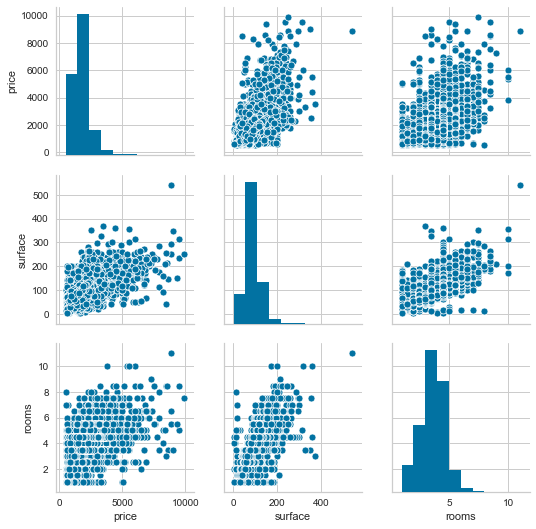

In [184]:
ax = sns.pairplot(d)

In [185]:
price_per_canton = d.groupby('canton').agg({'price': 'mean'}).sort_values('price',ascending=False).reset_index()

In [186]:
price_per_canton.head()

,canton,price
0,Zoug,3184.567164
1,Genève,2742.858162
2,Zurich,2238.417231
3,Schwytz,2207.979228
4,Nidwald,2162.666667


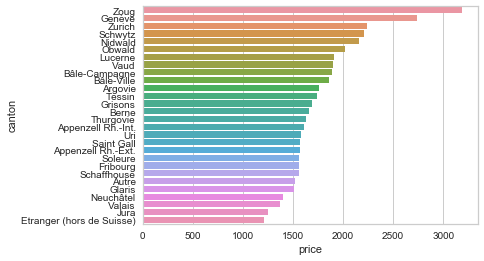

In [187]:
ax = sns.barplot(x="price", y="canton", data=price_per_canton)

It looks like the price of housing is different in different cantons (or the size of the appartment are different).

In [188]:
X = d[['surface','rooms']]
y = d['price']

In [189]:
lm = LinearRegression(fit_intercept=True).fit(X,y)

In [190]:
y_pred = lm.predict(X)

In [191]:
RMSE_lm =  ((y-y_pred)**2).values.mean()**0.5

In [192]:
results = pd.DataFrame()
results["Method"] = ["Linear Regression"]
results["RMSE"] = RMSE_lm
results

,Method,RMSE
0,Linear Regression,546.52623


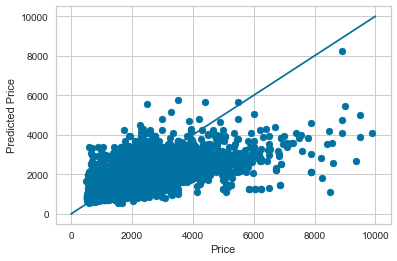

In [193]:
plot = plt.scatter(y,y_pred)
plot = plt.plot([0,10000],[0,10000])
plot = plt.xlabel("Price")
plot = plt.ylabel("Predicted Price")

It looks like the price prediction is off for very expensive appartments. We predict much cheaper price than the real prices.

In [194]:
d.head()

,title,price,surface,rooms,object,location,canton
2,Croix de Rozon 3 kms de Carouge à louer 4 pcs,2150.0,80.0,4.0,Appartement,La Croix-de-Rozon,Genève
4,Chambre a louer,600.0,30.0,2.0,Appartement,Vétroz,Valais
7,Appartements Neufs,750.0,29.0,1.5,Appartement,Neuchâtel,Neuchâtel
8,"Un beau grand loft, vaste, lumineux et proche ...",2270.0,145.0,3.0,Appartement,Neuchâtel,Neuchâtel
11,1 chambre en colocation dans un Duplex,827.0,100.0,5.0,Appartement,Lausanne,Vaud


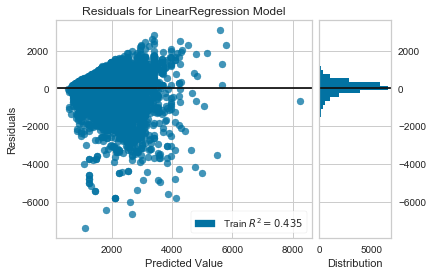

In [195]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X, y)
visualizer.poof()

In [196]:
X = sm.add_constant(X)

/anaconda3/envs/anibis_immo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [197]:
lm2 = sm.OLS(y,X).fit()

In [198]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     9757.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:32:12   Log-Likelihood:            -1.9614e+05
No. Observations:               25398   AIC:                         3.923e+05
Df Residuals:                   25395   BIC:                         3.923e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        516.3980     11.253     45.890      0.000     494.342     538.454
surface       14.1865      0.174     81.722      0.000      13.846      14.527
rooms          6.5743      5.166      1.273      0.203      -3.551      16.699
==============================================================================
Omnibus:                    15895.483   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           361291.687
Skew:                           2.624   Prob(JB):                         0.00
Kurtosis:                      20.716   Cond. No.                         316.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

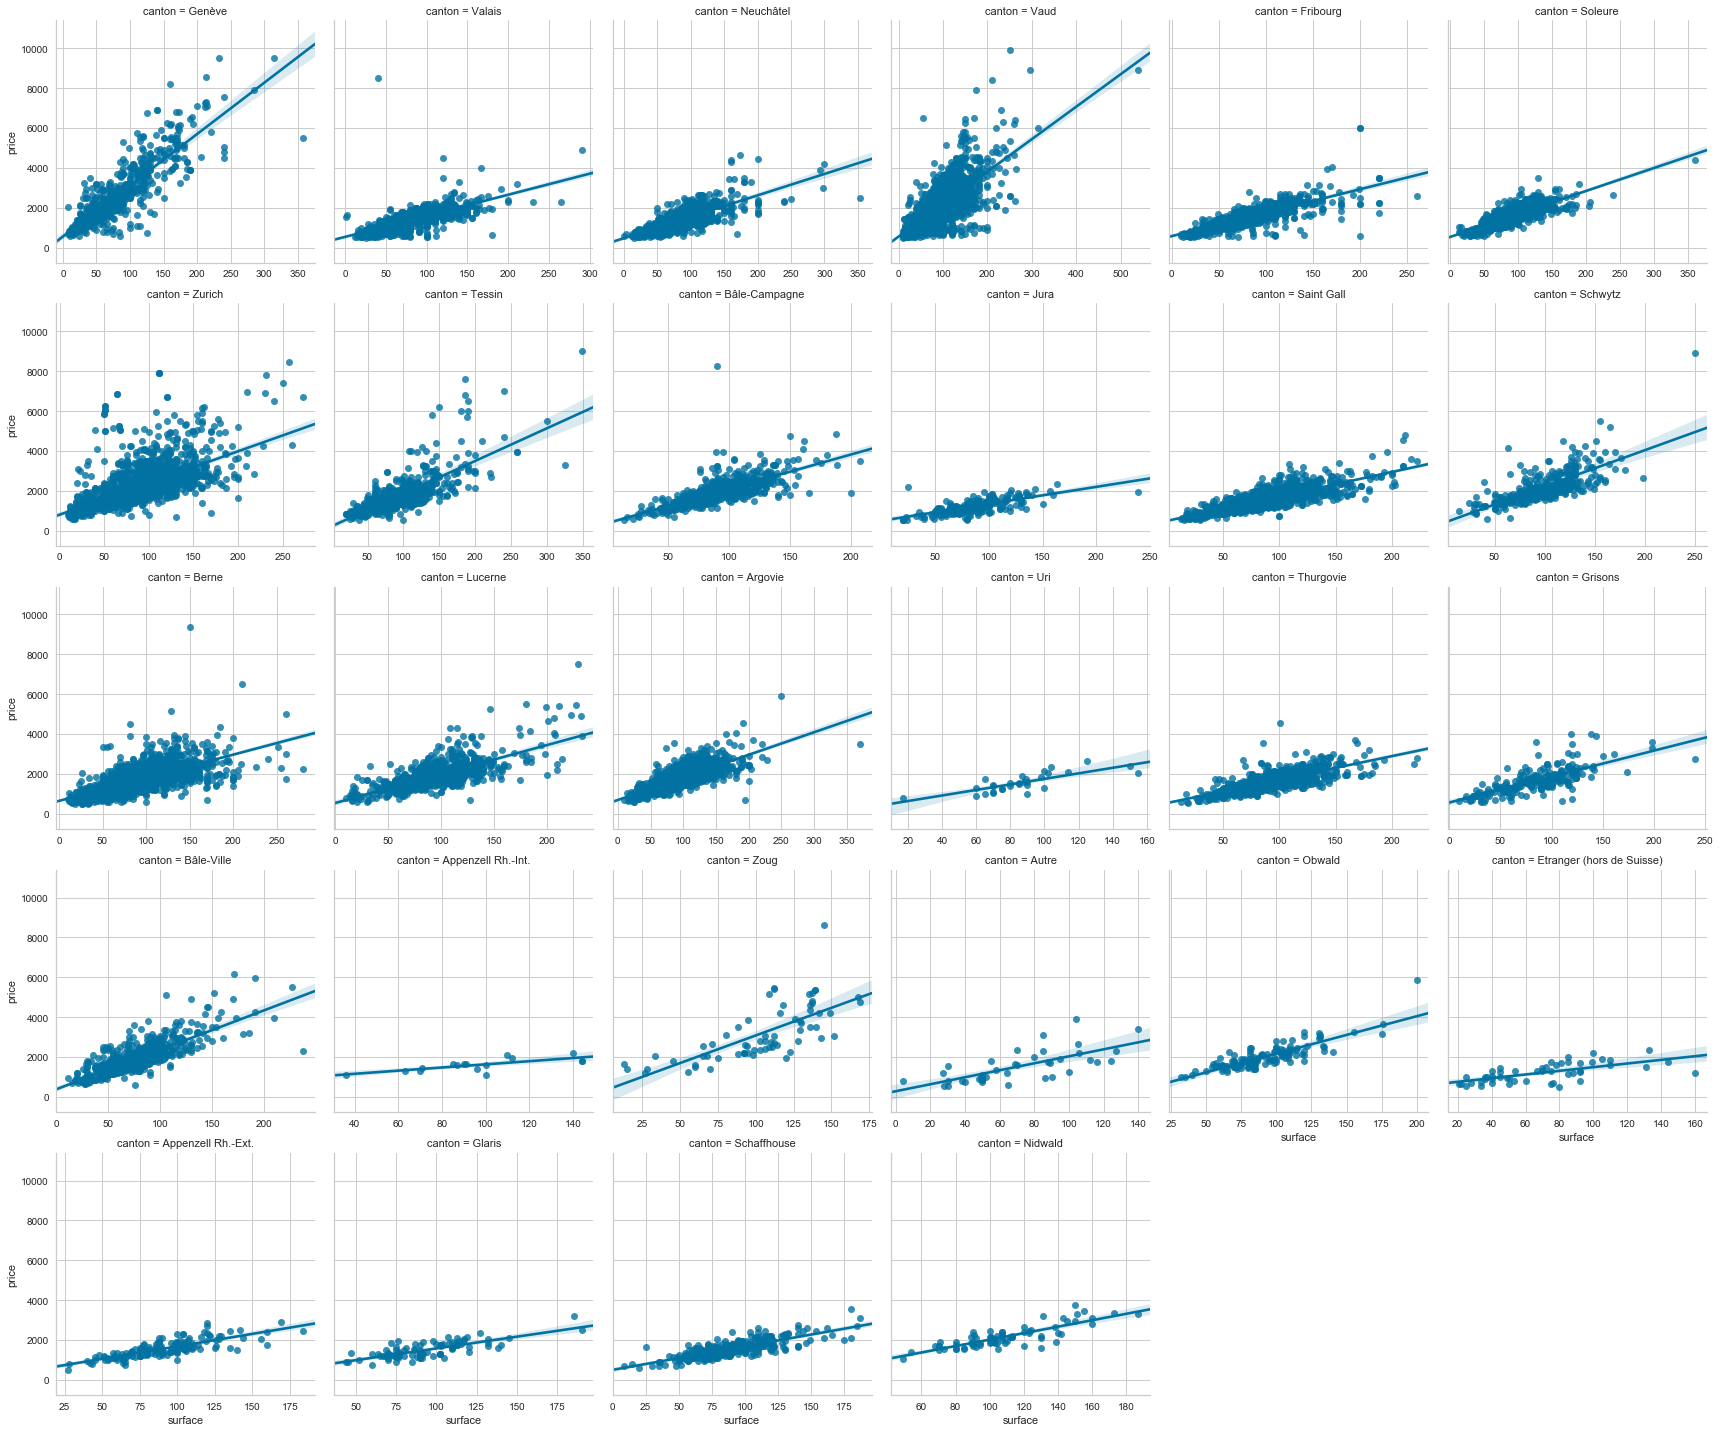

In [199]:
grid = sns.lmplot(x = "surface", y = "price", col = "canton", sharex=False, col_wrap = 6, data = d, height=4)

We will fist add a fixed effect for each canton

In [200]:
d = pd.concat([d,pd.get_dummies(d['canton'])],axis=1)

In [201]:
cantons = d['canton'].unique()
X = pd.concat([d[['rooms','surface']],d[cantons]],axis=1)
y = d['price']

In [202]:
lm3 = LinearRegression(fit_intercept=True)
lm3 = lm3.fit(X,y)
y_pred = lm3.predict(X)

In [203]:
RMSE_lm =  ((y-y_pred)**2).values.mean()**0.5

In [204]:
results.loc[1] = ["Fixed_cantons", RMSE_lm]
results

,Method,RMSE
0,Linear Regression,546.526230
1,Fixed_cantons,468.524794


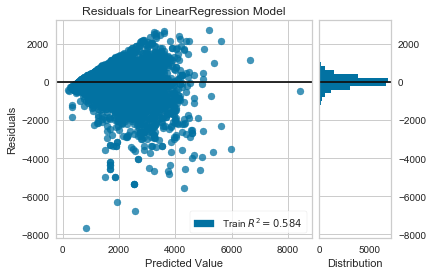

In [38]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X, y)
visualizer.poof()

We can run a linear mixed model as we do not care about the precise effect of canton

In [39]:
lm3 = smf.mixedlm("price ~ surface + rooms", d, groups=d["canton"]).fit()

In [40]:
lm3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: price       
No. Observations: 25398   Method:             REML        
No. Groups:       28      Scale:              219776.6541 
Min. group size:  16      Likelihood:         -192310.8000
Max. group size:  3775    Converged:          Yes         
Mean group size:  907.1                                   
----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    496.776   72.614  6.841 0.000 354.455 639.096
surface       14.026    0.150 93.488 0.000  13.732  14.320
rooms         13.861    4.489  3.087 0.002   5.062  22.660
Group Var 143418.788   83.944                             
==========================================================

"""

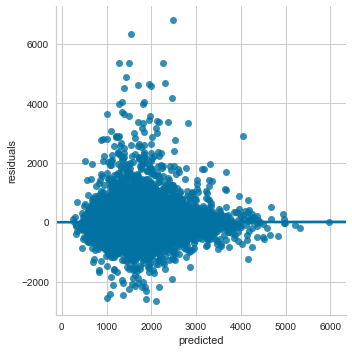

In [41]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = lm3.resid.values
performance["predicted"] = lm3.fittedvalues

plot = sns.lmplot(x = "predicted", y = "residuals", data = performance)

In [42]:
# and let's store the rmse
y_predict = lm3.fittedvalues
RMSE_lm =  ((y-y_predict)**2).values.mean()**0.5
results.loc[2] = ["Mixed_cantons", RMSE_lm]
results

,Method,RMSE
0,Linear Regression,546.526230
1,Fixed,468.524794
2,Mixed,468.528040


Mixed model with random slope

In [54]:
lm4 = smf.mixedlm("price ~ surface + rooms", d, groups=d["canton"], re_formula="~surface+rooms").fit()

In [55]:
y_predict = lm4.fittedvalues
RMSE_lm =  ((y-y_predict)**2).values.mean()**0.5
results.loc[3] = ["Mixed_random_slopes", RMSE_lm]
results

,Method,RMSE
0,Linear Regression,546.526230
1,Fixed,468.524794
2,Mixed,468.528040
3,Mixed_random_slopes,448.127565
4,Mixed_random_slope_surface,451.567274


In [72]:
lm5 = smf.mixedlm("price ~ surface + rooms", d, groups=d["location"]).fit()

In [73]:
y_predict = lm5.fittedvalues
RMSE_lm =  ((y-y_predict)**2).values.mean()**0.5
results.loc[4] = ["Mixed_location", RMSE_lm]
results

,Method,RMSE
0,Linear Regression,546.526230
1,Fixed,468.524794
2,Mixed,468.528040
3,Mixed_random_slopes_location,326.009426
4,Mixed_random_slopes_location,385.668740
